In [1]:
from products.snow_cover_product import MeteoFranceSNPPPrototype, VNP10A1, VJ110A1

analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/'
product_list = [ VNP10A1(), VJ110A1(), MeteoFranceSNPPPrototype()]


In [2]:
from typing import List
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from postprocess.error_distribution import line_plot_rmse, plot_custom_spans
import matplotlib.patches as mpatches
from postprocess.skill_scores import line_plot_accuracy_f1_score, line_plot_total_count
from products.snow_cover_product import SnowCoverProduct


def plot_one_var_analysis(snow_cover_products: List[SnowCoverProduct],analysis_folder: str, analysis_var:str, axs: List[Axes]):
        line_plot_accuracy_f1_score(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder, analysis_var=analysis_var,ax=axs[0])
        line_plot_rmse(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder, analysis_var=analysis_var,ax=axs[1])
        plot_custom_spans(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder,analysis_var=analysis_var, ax=axs[2])
        line_plot_total_count(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder,analysis_var=analysis_var, ax=axs[-1])
def plot_grid(snow_cover_products: List[SnowCoverProduct],analysis_folder: str, params_list:List[str], axs: List[Axes]):
    for i, var in enumerate(params_list):
        if var=="View Zenith Angle [°]":
            plot_one_var_analysis(snow_cover_products=snow_cover_products, 
                                  analysis_folder=analysis_folder,
                                  analysis_var=var,
                                  axs=axs[i])
        else:
            plot_one_var_analysis(snow_cover_products, analysis_folder, var,axs[i])



/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/src/postprocess/general_purpose.py:161: SyntaxWarning: invalid escape sequence '\%'
  rename_dict.update({"ref_bins": "Ref FSC [\%]"})


<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_13877/2967922139.py:5: SyntaxWarning: invalid escape sequence '\%'
  params = ["Ref FSC [\%]","Aspect", "Landcover", "Slope [°]"]


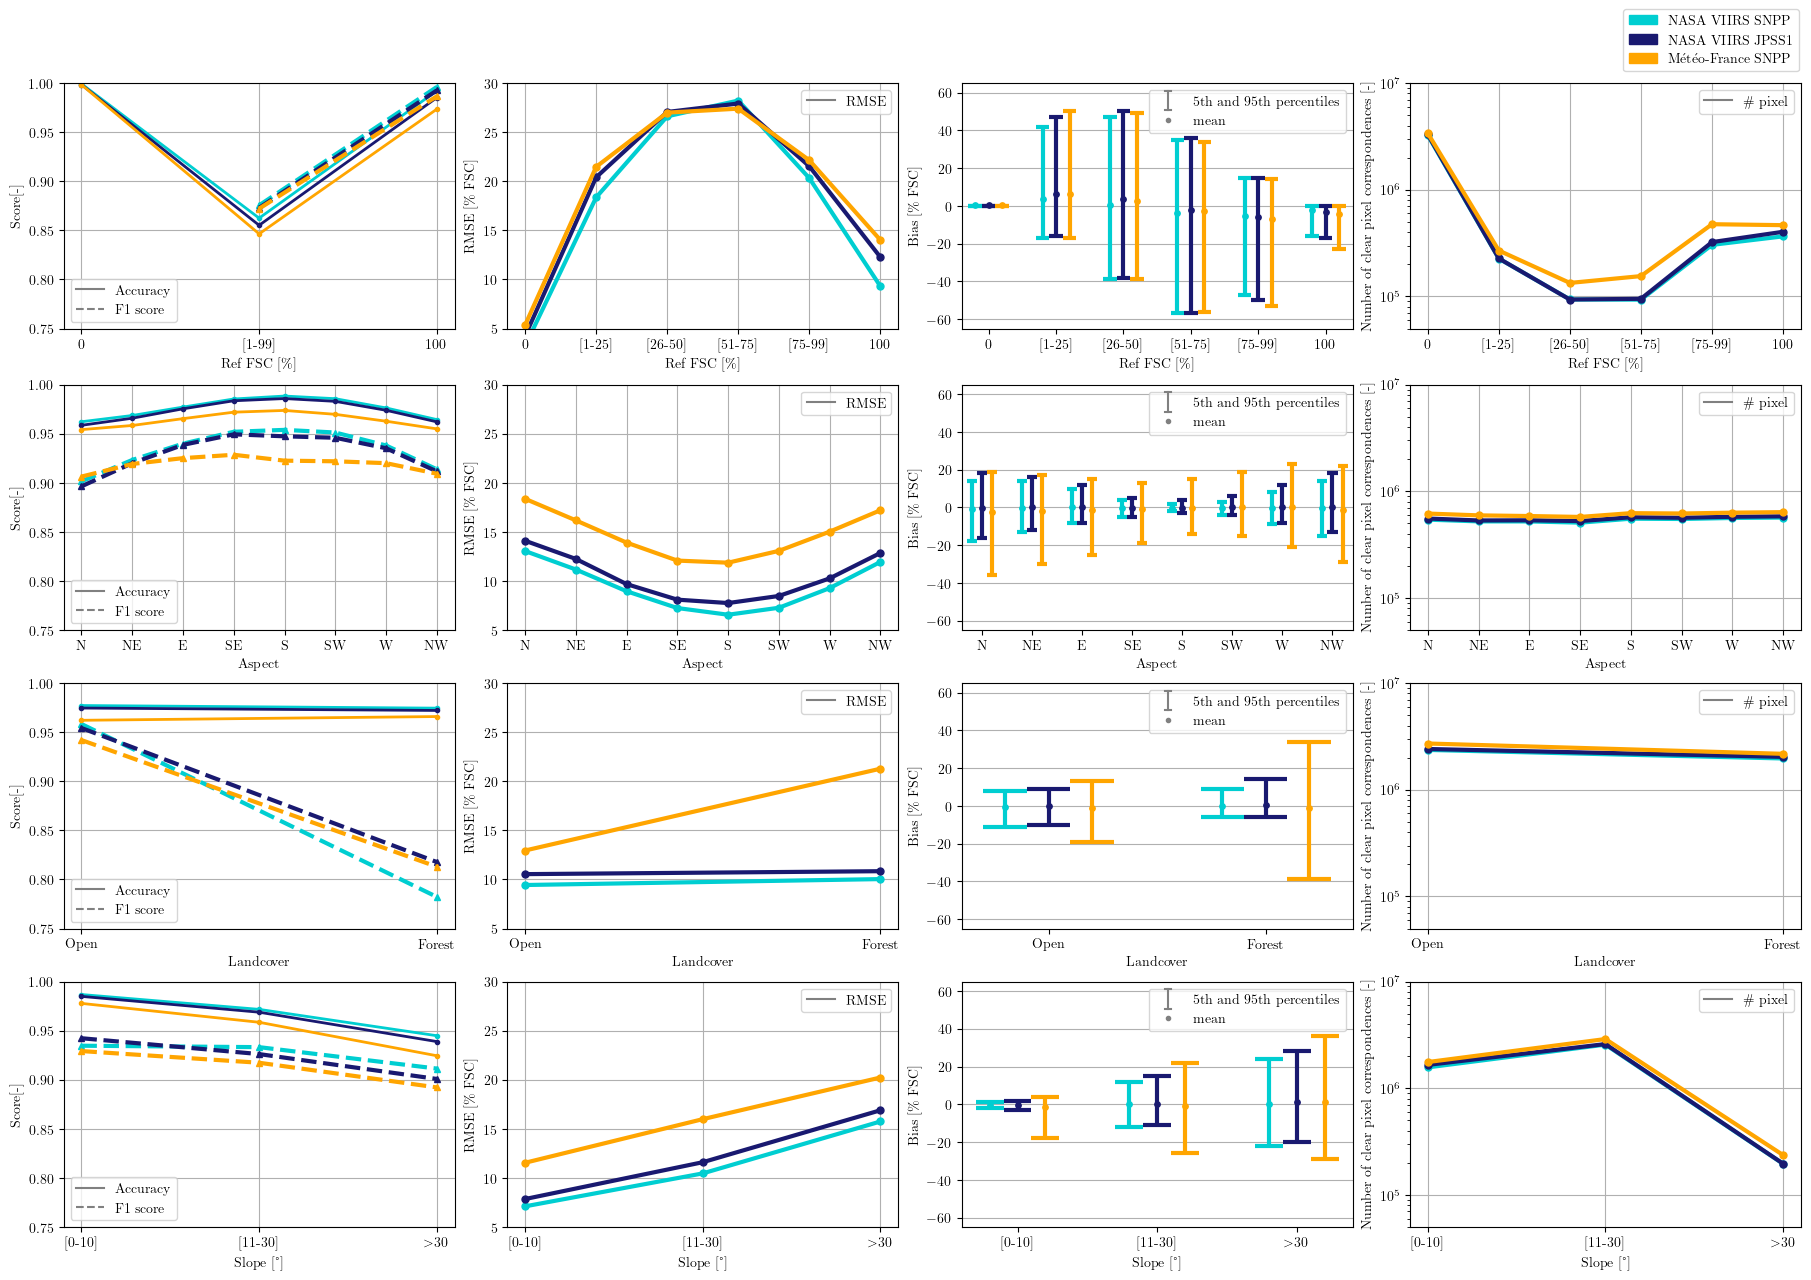

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
params = ["Ref FSC [\%]","Aspect", "Landcover", "Slope [°]"] 
fig, axs = plt.subplots(len(params), 4, figsize=(18,3  * len(params)), layout="constrained")
plot_grid(snow_cover_products=product_list,analysis_folder=analysis_folder,params_list=params, axs=axs)
# plot_product_legend(snow_cover_products=product_list, legend_ax=axs[0,1])
custom_leg = [
        mpatches.Patch(color=product.plot_color, label=product.plot_name)
        for product in product_list
    ]
fig.legend(handles=custom_leg, bbox_to_anchor=(1,1.06))
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/synthesis_scores_plot.png', format='png',bbox_inches='tight')

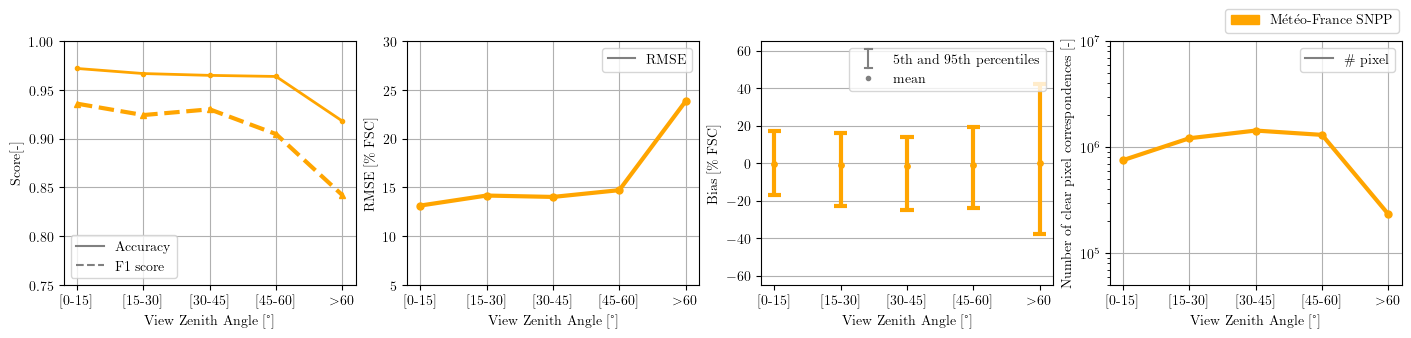

In [4]:
from products.snow_cover_product import MeteoFranceSNPPPrototype
from matplotlib import pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8_sensor_zenith/'
product_list = [ MeteoFranceSNPPPrototype()]
params = ["View Zenith Angle [°]"] 
fig, axs = plt.subplots(len(params), 4, figsize=(14,3  * len(params)), layout="constrained")
plot_one_var_analysis(snow_cover_products=product_list,analysis_folder=analysis_folder,analysis_var=params[0], axs=axs)
# plot_product_legend(snow_cover_products=product_list, legend_ax=axs[1]) 

custom_leg = [
        mpatches.Patch(color=product.plot_color, label=product.plot_name)
        for product in product_list
    ]
# product_legend =legend_ax.legend(handles=custom_leg, loc=(1,0))
fig.legend(handles=custom_leg, bbox_to_anchor=(1,1.1))
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/synthesis_scores_plot_sza.png', format='png',bbox_inches='tight')

In [5]:
from typing import List

import numpy as np
from matplotlib import patches, ticker
from matplotlib.axes import Axes

from postprocess.error_distribution import postprocess_uncertainty_analysis
from postprocess.general_purpose import open_reduced_dataset, open_reduced_dataset_completeness, open_reduced_dataset_for_plot
from products.snow_cover_product import SnowCoverProduct


def annual_area_fancy_plot(
    snow_cover_products: List[SnowCoverProduct],
    analysis_folder: str,
    axs: List[Axes] | None = None,
):
    [ax.set_ylabel("Area [km²]") for ax in axs[:1]]
    axs[1].set_ylabel("RMSE [\% FSC]")
    custom_leg = [patches.Patch(color=product.plot_color, label=product.plot_name) for product in snow_cover_products]
    product_legend = axs[0].legend(handles=custom_leg, loc=[0.8, 0.45])
    axs[0].add_artist(product_legend)
    for product in snow_cover_products:
        metrics_dataset_completeness = open_reduced_dataset_completeness(product=product, analysis_folder=analysis_folder).sel(
            time=slice("2023-11", "2024-06"), altitude_bins=slice(900, None)
        )
        product_monthly_averages = (
            metrics_dataset_completeness.resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )
        product_monthly_averages = product_monthly_averages.sum(
            dim=[d for d in product_monthly_averages.dims if d != "time" and d != "class_name"]
        )

        snow_cover = product_monthly_averages.sel(class_name="snow_cover")
        clouds = product_monthly_averages.sel(class_name="clouds")
        time_ax = np.arange(snow_cover.sizes["time"])
        if "jpss2" in product.name:
            time_ax = time_ax + 6

        axs[0].plot(time_ax, snow_cover, ".-", color=product.plot_color, lw=2)
        axs[1].plot(time_ax, clouds, ".-", color=product.plot_color, lw=2)
        metrics_dataset_uncertainty = (
            open_reduced_dataset(product=product, analysis_folder=analysis_folder, analysis_type="uncertainty")
            .sel(time=slice("2023-11", "2024-06"), altitude_bins=slice(900, None))
            .resample({"time": "1ME"})
            .sum()
        )
        metrics_dataset_uncertainty = postprocess_uncertainty_analysis(
            snow_cover_products=[product], metrics_datasets=[metrics_dataset_uncertainty], analysis_var="time"
        )
        axs[2].plot(time_ax, metrics_dataset_uncertainty.sel(product=product.name).rmse, "^-", color=product.plot_color, lw=2)

    axs[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[0].set_ylim(bottom=0)
    axs[1].set_ylim(bottom=0)
    axs[-1].set_ylim(0, 20)
    [ax.grid() for ax in axs]
    axs[0].set_title("Snow cover")
    axs[1].set_title("Clouds")
    axs[-1].set_title("RMSE")
    axs[-1].set_xticks(np.arange(product_monthly_averages.sizes["time"]))
    axs[-1].set_xticklabels(product_monthly_averages.coords["time"].to_dataframe().index.strftime("%B"))


<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_6844/2665693858.py:18: SyntaxWarning: invalid escape sequence '\%'
  axs[1].set_ylabel("RMSE [\% FSC]")


<Figure size 640x480 with 0 Axes>

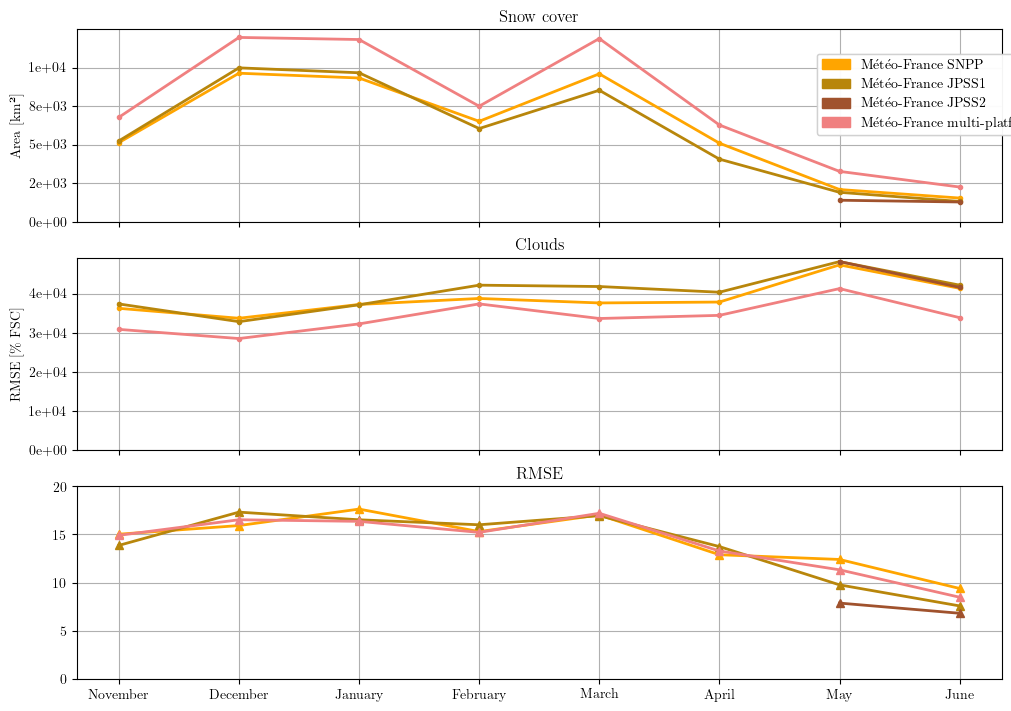

In [6]:
from products.snow_cover_product import MeteoFranceSNPPPrototype, MeteoFranceJPSS1Prototype, MeteoFranceJPSS2Prototype, MeteoFranceMultiplatformPrototype
from matplotlib import pyplot as plt

analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/'
product_list = [MeteoFranceSNPPPrototype(),MeteoFranceJPSS1Prototype(),  MeteoFranceJPSS2Prototype(),MeteoFranceMultiplatformPrototype()]

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

plt.subplots_adjust(bottom=0.18)
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True, layout="constrained")
annual_area_fancy_plot(snow_cover_products=product_list, analysis_folder=analysis_folder, axs=axs)
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/multiplatform_composite.png', format='png',bbox_inches='tight')

In [3]:
375*375/1e6

0.140625

<>:67: SyntaxWarning: invalid escape sequence '\%'
<>:68: SyntaxWarning: invalid escape sequence '\%'
<>:67: SyntaxWarning: invalid escape sequence '\%'
<>:68: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_62342/1637128566.py:67: SyntaxWarning: invalid escape sequence '\%'
  ax[i].set_ylabel("S2 FSC [\%]")
/tmp/ipykernel_62342/1637128566.py:68: SyntaxWarning: invalid escape sequence '\%'
  ax[i].set_xlabel("VNP10A1 NDSI [\%]")


<Figure size 640x480 with 0 Axes>

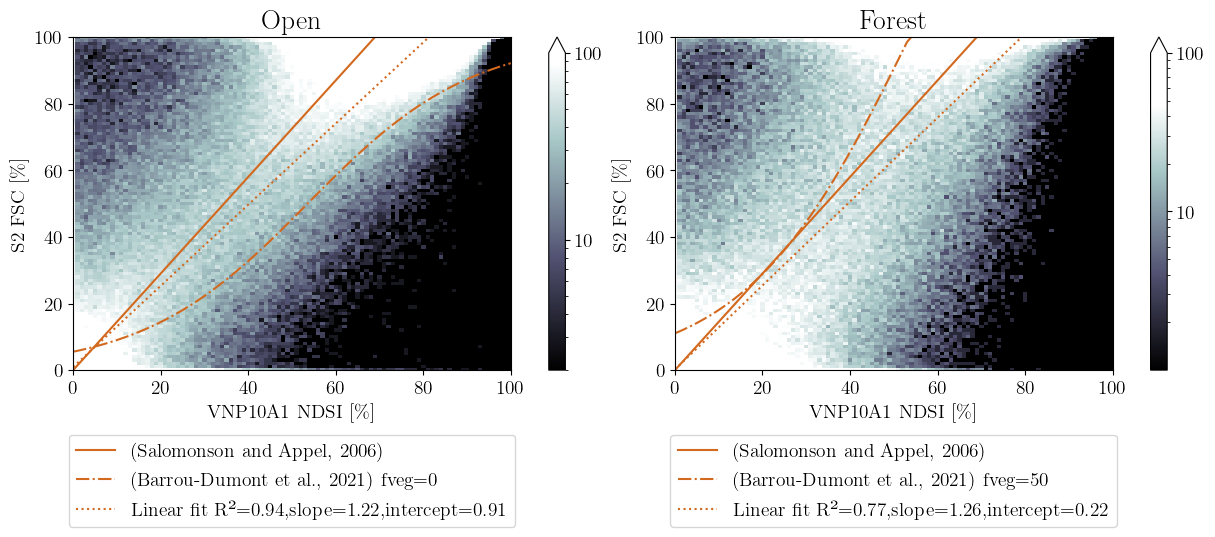

Salomonson Appel R score 0.91, 0.75


In [22]:

### NDSI-FSC regression
from matplotlib.axes import Axes
from fractional_snow_cover import gascoin, salomonson_appel
from postprocess.scatter_plot import fancy_scatter_plot
import xarray as xr
import matplotlib.pyplot as plt


analysis_type = "scatter"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/"
)

nasa_l3_snpp_metrics_ds = xr.open_dataset(
    f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_S2_theia.nc"
)
# nasa_l3_snpp_metrics_ds = nasa_l3_snpp_metrics_ds.where(nasa_l3_snpp_metrics_ds > 0, drop=True)

# plt.rcParams["font.family"] = "Noto Sans"
# font = {'family' : 'Sans Serif',
#         'weight' : 'normal',
#         'size'   : 20}

# matplotlib.rc('font', **font)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 14
})

plt.subplots_adjust(bottom=0.18)
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharex=True, layout="constrained")


# ax[0].set_facecolor('#222')
FOREST_TITLE = {'no_forest': 'Open', 'forest': 'Forest'}
for i, fore in enumerate(["no_forest", "forest"]):

    n_min = 0
    # fig.suptitle("Scatter plot VIIRS NDSI_Snow_Cover vs S2 FSC")
    reduced = (
        nasa_l3_snpp_metrics_ds.sel(
            ref_bins=slice(0, 100),
            forest_mask_bins=[fore],
            test_bins=slice(0, 100),
        )
        .sum(dim=("forest_mask_bins", "time", "altitude_bins"))
        .data_vars["n_occurrences"]
    )

    xax = reduced.test_bins.values
    f_veg=0 if fore=="no_forest" else 0.5
    fit_g = gascoin(xax * 0.01, f_veg=f_veg) * 100
    ax[i].plot(xax, salomonson_appel(xax), color="chocolate", linewidth=1.5, label="(Salomonson and Appel, 2006)")
    ax[i].plot(xax, fit_g,"-.",color="chocolate", linewidth=1.5, label=f"(Barrou-Dumont et al., 2021)  fveg={int(f_veg*100)}%")

    scatter_plot = fancy_scatter_plot(
        data_to_plt=reduced.rename({"ref_bins": "y", "test_bins": "x"}),
        ax=ax[i],
        figure=fig,
        low_threshold=None,
        smoothing_window_size=None,
    )
    # ax[i].set_title(PRODUCT_PLOT_NAMES[k])
    ax[i].set_ylabel("S2 FSC [\%]")
    ax[i].set_xlabel("VNP10A1 NDSI [\%]")
    ax[i].set_title(FOREST_TITLE[fore], fontsize=20)
    ax[i].set_ylim(0,100)
    ax[i].set_xlim(0,100)


plt.show()

fig.patch.set_alpha(0.0)
print("Salomonson Appel R score 0.91, 0.75")
# fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/scatter_plot.png', format='png',bbox_inches='tight')

In [24]:
import xarray as xr

ds = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_nasa_l3_snpp.nc')
ds= ds.sel(time=slice('2023-11', '2024-06'))
snow_cover = ds.data_vars['surface'].sel(class_name='snow_cover').sum(dim=('altitude_bins', 'time', 'forest_mask_bins')).values
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water']).sum().values
print("Snow cover percentage of valid observations for the study area")
print(snow_cover/total*100)

ds = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_nasa_l3_snpp.nc')
ds= ds.sel(altitude_bins=slice(900,None), time=slice('2023-11', '2024-06'))
snow_cover = ds.data_vars['surface'].sel(class_name='snow_cover').sum(dim=('altitude_bins', 'time', 'forest_mask_bins')).values
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water']).sum().values
print("Snow cover percentage of valid observations for the study area with 900 m altitude threshold")
print(snow_cover/total*100)

snow_cover_forest = ds.data_vars['surface'].sel(class_name='snow_cover', forest_mask_bins='forest').sum(dim=('altitude_bins', 'time')).values
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water'], forest_mask_bins='forest').sum().values
print("Snow cover percentage of valid observations for the study area with 900 m altitude threshold in open areas")
print(snow_cover_forest/total*100)

snow_cover_no_forest = ds.data_vars['surface'].sel(class_name='snow_cover', forest_mask_bins='no_forest').sum(dim=('altitude_bins', 'time')).values
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water'], forest_mask_bins='no_forest').sum().values
print("Snow cover percentage of valid observations for the study area with 900 m altitude threshold in forest areas")
print(snow_cover/total*100)

Snow cover percentage of valid observations for the study area
20.564300068700177
Snow cover percentage of valid observations for the study area with 900 m altitude threshold
31.431908768832695
Snow cover percentage of valid observations for the study area with 900 m altitude threshold in open areas
21.59747756081099
Snow cover percentage of valid observations for the study area with 900 m altitude threshold in forest areas
56.96711507773282


In [33]:
import xarray as xr

ds_snpp = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_meteofrance_prototype_snpp.nc')
ds_jpss1 = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_meteofrance_prototype_jpss1.nc')
ds_multiplatform = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_meteofrance_prototype_multiplatform.nc')

clouds_snpp = ds_snpp.data_vars['surface'].sel(class_name='clouds').sum(dim=('altitude_bins', 'time', 'forest_mask_bins')).values
clouds_jpss1 = ds_jpss1.data_vars['surface'].sel(class_name='clouds').sum(dim=('altitude_bins', 'time','forest_mask_bins')).values
clouds_multiplatform = ds_multiplatform.data_vars['surface'].sel(class_name='clouds').sum(dim=('altitude_bins', 'time')).values

print("Cloud cover reduction from SNPP to multiplatform")
print((clouds_snpp - clouds_multiplatform)/clouds_snpp * 100)
print("Cloud cover reduction from JPSS-1 to multiplatform")
print((clouds_jpss1 - clouds_multiplatform)/clouds_jpss1 *100)

Cloud cover reduction from SNPP to multiplatform
8.885516284916674
Cloud cover reduction from JPSS-1 to multiplatform
11.43227173877166


In [34]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from pandas.io.formats.style import Styler

from postprocess.error_distribution import compute_uncertainty_results_df
from postprocess.general_purpose import fancy_table,open_reduced_dataset
from postprocess.skill_scores import compute_contingency_results_df, compute_n_pixels_results_df
from products.snow_cover_product import VJ110A1, VNP10A1, MeteoFranceSNPPPrototype, SnowCoverProduct
import dataframe_image as dfi

from IPython.display import display

from products.snow_cover_product import VNP10A1




def fancy_table_tot(dataframe_to_print: pd.DataFrame) -> Styler:
    # Get the built-in RdYlGn colormap
    base_cmap = plt.get_cmap("RdYlGn")

    # Sample the three anchor colors from RdYlGn:
    red = base_cmap(0.0)  # left end
    yellow = base_cmap(0.5)  # center (yellow in RdYlGn)
    green = base_cmap(1.0)  # right end
    colors_biais = [red, yellow, green, yellow, red]

    cmap_biais = LinearSegmentedColormap.from_list("green_center", colors_biais, N=256)
    color_maps = {
        "Accuracy": "RdYlGn",
        "F1-score": "RdYlGn",
        "Commission error": "RdYlGn_r",  # Lower is better
        "Omission error": "RdYlGn_r",
        "Bias [%]": cmap_biais,
        "RMSE [%]": "RdYlGn_r",
    }
    vmins = {
        "Accuracy": 0.6,  # Higher is better
        "F1-score": 0.6,
        "Commission error": 0,  # Lower is better (reversed Reds)
        "Omission error": 0,
        "Bias [%]": -5,
        "RMSE [%]": 5,
    }
    vmaxs = {
        "Accuracy": 1,  # Higher is better
        "F1-score": 1,
        "Commission error": 0.3,  # Lower is better
        "Omission error": 0.3,
        "Bias [%]": 5,
        "RMSE [%]": 30,
    }

    # Build the colormap

    # Apply gradient coloring
    return fancy_table(dataframe_to_print=dataframe_to_print, color_maps=color_maps, vmins=vmins, vmaxs=vmaxs)


analysis_folder = "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/"

product_list = [VNP10A1()]
refs = ["1-99 %", "0-100 %"]

df_list = []


for i, ref in enumerate([slice(25, 99), slice(None, None)]):
    for f in ["forest", "no_forest"]:
        for asp in ["N", "S"]:
            # for t in [ '2023-12',  '2024-04']:
            # print(f,asp,ref)
            selection = dict(altitude_bins=slice(900, None), ref_bins=ref, forest_mask_bins=f, aspect_bins=asp)
            uncertainty_list = [
                open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="uncertainty").sel(selection)
                for prod in product_list
            ]
            confusion_table_list = [
                open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="confusion_table").sel(selection)
                for prod in product_list
            ]
            df_cont = compute_contingency_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)
            df_cont["Reference FSC"] = refs[i]
            df_unc = compute_uncertainty_results_df(snow_cover_products=product_list, metric_datasets=uncertainty_list)[
                ["biais", "rmse"]
            ]
            df_n_pixels = compute_n_pixels_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)[
                ["n_tot_pixels", "n_snow_pixels"]
            ]
            df_n_pixels["percentage_snow_pixels"] = df_n_pixels["n_snow_pixels"] / df_n_pixels["n_tot_pixels"] * 100
            df_n_pixels = df_n_pixels[["n_tot_pixels", "percentage_snow_pixels"]]

            df_tot = pd.concat(
                [
                    df_cont[["Reference FSC", "forest_mask_bins", "aspect_bins"]],
                    df_n_pixels,
                    df_cont[["accuracy", "f1_score", "commission_error", "omission_error"]],
                    df_unc,
                ],
                axis=1,
            )

            df_tot = df_tot.rename(
                columns={
                    "forest_mask_bins": "Landcover",
                    "aspect_bins": "Aspect",
                    "n_tot_pixels": "# of pixels",
                    "percentage_snow_pixels": "% Snow Cover",
                    "accuracy": "Accuracy",
                    "f1_score": "F1-score",
                    "commission_error": "Commission error",
                    "omission_error": "Omission error",
                    "biais": "Bias [%]",
                    "rmse": "RMSE [%]",
                }
            )

            if df_tot.loc[0, "Landcover"] == "forest":
                df_tot["Landcover"] = "Forest"
            elif df_tot.loc[0, "Landcover"] == "no_forest":
                df_tot["Landcover"] = "Open"
            df_list.append(df_tot)
            # print(df_tot)
            # print("Worse")
            # fancy_table_skill_scores(df)


df_resume = pd.concat(df_list, ignore_index=True)
styled = fancy_table_tot(df_resume)

display(styled)
dfi.export(styled, "/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/table_vnp10a1.pdf", table_conversion="selenium") 


Reference FSC,Landcover,Aspect,# of pixels,% Snow Cover,Accuracy,F1-score,Commission error,Omission error,Bias [%],RMSE [%]
1-99 %,Forest,N,4.57e+04,38.36,0.77,0.69,0.17,0.33,-3.65,29.61
1-99 %,Forest,S,1.14e+04,40.53,0.84,0.79,0.11,0.24,-4.24,22.40
1-99 %,Open,N,5.82e+04,65.71,0.86,0.89,0.12,0.16,-5.39,23.76
1-99 %,Open,S,5.08e+04,61.28,0.91,0.93,0.11,0.07,0.09,17.35
0-100 %,Forest,N,3.07e+05,7.25,0.96,0.73,0.02,0.29,0.06,13.18
0-100 %,Forest,S,1.95e+05,3.11,0.99,0.83,0.00,0.19,-0.23,6.01
0-100 %,Open,N,2.36e+05,35.74,0.96,0.95,0.02,0.08,-1.63,12.90
0-100 %,Open,S,3.59e+05,17.75,0.99,0.97,0.01,0.03,-0.00,6.85


In [ ]:
from typing import  List

import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from pandas.io.formats.style import Styler

from postprocess.error_distribution import compute_uncertainty_results_df
from postprocess.general_purpose import  open_reduced_dataset
from postprocess.skill_scores import compute_contingency_results_df, compute_n_pixels_results_df
from products.snow_cover_product import VJ110A1, VNP10A1, MeteoFranceSNPPPrototype, SnowCoverProduct
import dataframe_image as dfi

import numpy as np
from IPython.display import display

from products.snow_cover_product import VNP10A1



def fancy_table_tot(dataframe_to_print: pd.DataFrame) -> Styler:
    # Get the built-in RdYlGn colormap
    base_cmap = plt.get_cmap("RdYlGn")

    # Sample the three anchor colors from RdYlGn:
    red = base_cmap(0.0)  # left end
    yellow = base_cmap(0.5)  # center (yellow in RdYlGn)
    green = base_cmap(1.0)  # right end
    colors_biais = [red, yellow, green, yellow, red]

    cmap_biais = LinearSegmentedColormap.from_list("green_center", colors_biais, N=256)
    color_maps = {
        "Accuracy": "RdYlGn",
        "F1-score": "RdYlGn",
        "Commission error": "RdYlGn_r",  # Lower is better
        "Omission error": "RdYlGn_r",
        "Bias [%]": cmap_biais,
        "RMSE [%]": "RdYlGn_r",
    }
    vmins = {
        "Accuracy": 0.6,  # Higher is better
        "F1-score": 0.6,
        "Commission error": 0,  # Lower is better (reversed Reds)
        "Omission error": 0,
        "Bias [%]": -5,
        "RMSE [%]": 5,
    }
    vmaxs = {
        "Accuracy": 1,  # Higher is better
        "F1-score": 1,
        "Commission error": 0.3,  # Lower is better
        "Omission error": 0.3,
        "Bias [%]": 5,
        "RMSE [%]": 30,
    }

    # Build the colormap

    # Apply gradient coloring
    return fancy_table(dataframe_to_print=dataframe_to_print, color_maps=color_maps, vmins=vmins, vmaxs=vmaxs)


analysis_folder = "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/"

product_list = [VNP10A1(), VJ110A1(), MeteoFranceSNPPPrototype()]

df_list = []
selection = dict(altitude_bins=slice(900, None))
uncertainty_list = [
    open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="uncertainty").sel(selection)
    for prod in product_list
]
confusion_table_list = [
    open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="confusion_table").sel(selection)
    for prod in product_list
]
df_cont = compute_contingency_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)
df_cont["Reference"] = refs[i]
df_unc = compute_uncertainty_results_df(snow_cover_products=product_list, metric_datasets=uncertainty_list)[
    ["biais", "rmse"]
]
df_n_pixels = compute_n_pixels_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)[
    ["n_tot_pixels", "n_snow_pixels"]
]
df_n_pixels["percentage_snow_pixels"] = df_n_pixels["n_snow_pixels"] / df_n_pixels["n_tot_pixels"] * 100
df_n_pixels = df_n_pixels[["n_tot_pixels", "percentage_snow_pixels"]]

df_tot = pd.concat(
    [
        df_cont[["product"]],
        df_n_pixels,
        df_cont[["accuracy", "f1_score", "commission_error", "omission_error"]],
        df_unc,
    ],
    axis=1,
)


df_tot = df_tot.rename(
    columns={
        "product": "Product",
        "n_tot_pixels": "# of pixels",
        "percentage_snow_pixels": "% Snow Cover",
        "accuracy": "Accuracy",
        "f1_score": "F1-score",
        "commission_error": "Commission error",
        "omission_error": "Omission error",
        "biais": "Bias [%]",
        "rmse": "RMSE [%]",
    }
)


df_list.append(df_tot)



df_resume = pd.concat(df_list, ignore_index=True)
df_resume=df_resume.replace("NASA VIIRS SNPP", "VNP10A1")
df_resume=df_resume.replace("NASA VIIRS JPSS1", "VJ110A1")

styled = fancy_table_tot(df_resume)

display(styled)
dfi.export(styled, "/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/table_multiproduct.pdf", table_conversion="selenium") 


Product,# of pixels,% Snow Cover,Accuracy,F1-score,Commission error,Omission error,Bias [%],RMSE [%]
VNP10A1,4.33e+06,17.72,0.98,0.93,0.01,0.07,-0.16,9.72
VJ110A1,4.45e+06,18.56,0.97,0.93,0.02,0.07,0.10,10.68
Météo-France SNPP,4.89e+06,22.54,0.96,0.92,0.02,0.10,-0.96,14.79
